In [4]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import gzip
from scipy.io import mmread
import matplotlib.pyplot as plt

In [5]:
datasets = ['humanBloodCells', 'humanKidneyCells', 'humanSkinCells']
dataset_index = 0
with gzip.open('./data/' + datasets[dataset_index] + '/matrix.mtx.gz', 'rt') as f:
  matrix = np.transpose(np.array(mmread(f).todense()))
  features = pd.read_csv('./data/' + datasets[dataset_index] + '/features.tsv.gz', sep='\t')
  barcodes = pd.read_csv('./data/' + datasets[dataset_index] + '/barcodes.tsv.gz', sep='\t')

In [6]:
num_nonzero = np.count_nonzero(matrix)
sparsity = np.count_nonzero(matrix) / matrix.size
print('Number of non-zero entries:', num_nonzero)
print('Matrix shape:', matrix.shape)
print('Sparsity:', f'{sparsity * 100}%')

Number of non-zero entries: 11598877
Matrix shape: (4661, 38616)
Sparsity: 6.444208067267334%


(array([1.15895e+07, 7.44100e+03, 1.01100e+03, 3.95000e+02, 2.03000e+02,
        9.60000e+01, 6.00000e+01, 3.90000e+01, 2.50000e+01, 1.40000e+01,
        9.00000e+00, 8.00000e+00, 8.00000e+00, 6.00000e+00, 4.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00

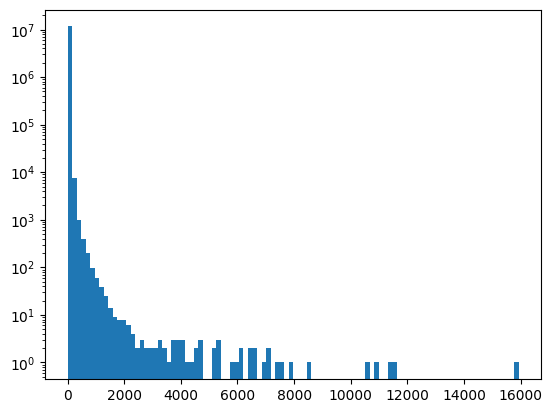

In [7]:
non_zero_vals = [i for i in matrix.reshape(matrix.size).tolist() if i != 0]
plt.hist(non_zero_vals, bins=100, log=True)

In [8]:
class Bitvector:
  def __init__(self):
    self.bits = bytearray()
    self.length = 0

  def append_bit(self, bit):
    if self.length % 8 == 0:
      self.bits.append(bit << 7)
    else:
      self.bits[-1] |= bit << (7 - self.length % 8)
    self.length += 1

  def append(self, val, length):
    for i in range(length - 1, -1, -1):
      self.append_bit((val >> i) & 1)

  def get(self, index):
    return self.bits[index // 8] >> (7 - index % 8) & 1

  def read(self, offset, length):
    num = 0
    for i in range(length):
      num <<= 1
      num += self.get(offset + i)
    return num

  def __len__(self):
    return self.length

In [9]:
SIZE_BITS = 32
METADATA_BITS = 8

In [10]:
matrix.shape

(4661, 38616)

In [21]:
def kmeans_structures(matrix, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(matrix)

  # Identify cluster representatives
  min_dists = np.zeros(n_clusters)
  reps = np.array([-1 for i in range(n_clusters)])
  for i in range(matrix.shape[0]):
    curr_dist = np.linalg.norm(matrix[i] - kmeans.cluster_centers_[kmeans.labels_[i]])
    if reps[kmeans.labels_[i]] == -1 or curr_dist < min_dists[kmeans.labels_[i]]:
      min_dists[kmeans.labels_[i]] = curr_dist
      reps[kmeans.labels_[i]] = i

  # Get delta matrix
  delta_matrix = np.copy(matrix)
  for i in range(matrix.shape[0]):
    if reps[kmeans.labels_[i]] == i:
      continue
    delta_matrix[i] = matrix[i] - matrix[reps[kmeans.labels_[i]]]

  return reps, kmeans.labels_, delta_matrix

def kmeans_compression(kmeans_data, n_clusters, output_filename):
  reps, labels, delta_matrix = kmeans_data
  bitvector = Bitvector()

  # Compress metadata values
  bitvector.append(delta_matrix.shape[0], SIZE_BITS)
  bitvector.append(delta_matrix.shape[1], SIZE_BITS)
  bitvector.append(n_clusters, METADATA_BITS)

  bits_per_m_index = delta_matrix.shape[0].bit_length()
  bits_per_n_index = delta_matrix.shape[1].bit_length()
  bits_per_cluster_index = n_clusters.bit_length()

  # Compress cluster membership information
  for rep in reps:
    bitvector.append(rep, bits_per_m_index)

  for label in labels:
    bitvector.append(label, bits_per_cluster_index)

  # Compress cluster representatives
  for i in range(n_clusters):
    row = delta_matrix[reps[i]]
    num_nonzero = np.count_nonzero(row)
    bits_per_val = int(np.max(row)).bit_length()
    bitvector.append(num_nonzero, bits_per_n_index)
    bitvector.append(bits_per_val, METADATA_BITS)
    for j in range(row.shape[0]):
      if row[j] != 0:
        bitvector.append(j, bits_per_n_index)
        bitvector.append(row[j], bits_per_val)

  # Compress other vectors
  for i in range(delta_matrix.shape[0]):
    if reps[labels[i]] == i:
      continue
    delta = delta_matrix[i]
    num_nonzero = np.count_nonzero(delta)
    bits_per_val = int(np.max(np.abs(delta))).bit_length()
    bitvector.append(num_nonzero, bits_per_n_index)
    bitvector.append(bits_per_val, METADATA_BITS)
    for j in range(delta.shape[0]):
      if delta[j] != 0:
        bitvector.append_bit(1 if delta[j] < 0 else 0)
        bitvector.append(j, bits_per_n_index)
        bitvector.append(abs(delta[j]), bits_per_val)
    
  with open(output_filename, 'wb') as f:
    f.write(bitvector.bits)

def kmeans_decompression(input_filename):
  bitvector = Bitvector()
  with open(input_filename, 'rb') as f:
    bitvector.bits = f.read()
    bitvector.length = len(bitvector.bits) * 8

  # Decompress metadata
  curr_index = 0
  m = bitvector.read(curr_index, SIZE_BITS)
  curr_index += SIZE_BITS
  n = bitvector.read(curr_index, SIZE_BITS)
  curr_index += SIZE_BITS
  n_clusters = bitvector.read(curr_index, METADATA_BITS)
  curr_index += METADATA_BITS

  bits_per_m_index = m.bit_length()
  bits_per_n_index = n.bit_length()
  bits_per_cluster_index = n_clusters.bit_length()
  
  # Decompress cluster membership information
  reps = []
  for i in range(n_clusters):
    reps.append(bitvector.read(curr_index, bits_per_m_index))
    curr_index += bits_per_m_index

  labels = []
  for i in range(m):
    labels.append(bitvector.read(curr_index, bits_per_cluster_index))
    curr_index += bits_per_cluster_index

  # Decompress cluster representatives
  matrix = np.zeros((m, n))
  for i in range(n_clusters):
    num_nonzero = bitvector.read(curr_index, bits_per_n_index)
    curr_index += bits_per_n_index
    bits_per_val = bitvector.read(curr_index, METADATA_BITS)
    curr_index += METADATA_BITS
    for j in range(num_nonzero):
      index = bitvector.read(curr_index, bits_per_n_index)
      curr_index += bits_per_n_index
      val = bitvector.read(curr_index, bits_per_val)
      curr_index += bits_per_val
      matrix[reps[i]][index] = val
  
  # Decompress other vectors
  for i in range(m):
    if reps[labels[i]] == i:
      continue
    num_nonzero = bitvector.read(curr_index, bits_per_n_index)
    curr_index += bits_per_n_index
    bits_per_val = bitvector.read(curr_index, METADATA_BITS)
    curr_index += METADATA_BITS
    for j in range(num_nonzero):
      sign = bitvector.read(curr_index, 1)
      curr_index += 1
      index = bitvector.read(curr_index, bits_per_n_index)
      curr_index += bits_per_n_index
      val = bitvector.read(curr_index, bits_per_val)
      curr_index += bits_per_val
      matrix[i][index] = val if sign == 0 else -val
    matrix[i] += matrix[reps[labels[i]]]

  return matrix

In [12]:
reps, labels, delta_matrix = kmeans_structures(matrix, 10)

In [19]:
kmeans_compression((reps, labels, delta_matrix), 10, 'test.bin')

In [22]:
decompressed = kmeans_decompression('test.bin')

In [23]:
np.array_equal(matrix, decompressed)

True

In [ ]:
print(matrix)
print(decompressed)

[[ 0  0  1]
 [ 0 15  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  1  1]]
[[ 0.  0.  1.]
 [ 0. 15.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]]


In [ ]:
k_vals = [10, 25, 50, 75, 100]
for k in k_vals:
  kmeans_compression(matrix, k, f'')